Weibull Fitter Summary:
              coef  se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  22.329118  1.165483       20.044813       24.613424     1.0   
rho_      1.531809  0.094895        1.345818        1.717801     1.0   

                 z             p    -log2(p)  
lambda_  18.300664  8.174631e-75  246.113454  
rho_      5.604160  2.092670e-08   25.510080  

Makeham-Gompertz Fitter Summary:
              coef  se(coef)  coef lower 95%  coef upper 95%  cmp to  \
c     1.000000e-09  0.031118       -0.060991        0.060991     1.0   
eta   2.502192e-02  0.026638       -0.027188        0.077232     1.0   
alfa  4.080705e-02  0.022664       -0.003613        0.085227     0.0   

              z              p    -log2(p)  
c    -32.135510  1.407762e-226  750.262346  
eta  -36.600865  2.770865e-293  971.854595  
alfa   1.800557   7.177276e-02    3.800420  

Goodness of Fit Comparison:
Weibull AIC: 1276.26
Makeham-Gompertz AIC: 1281.22
Weibull BIC: 1282.86
Makeham-Gomper

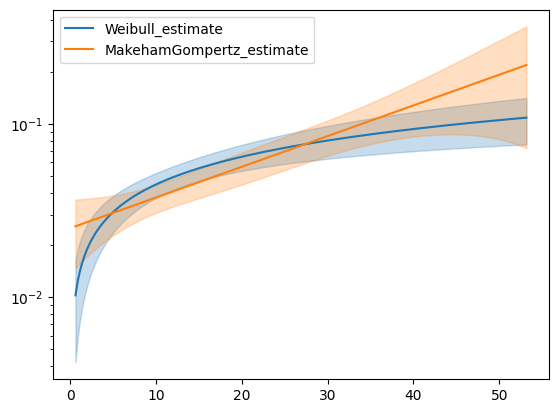

In [15]:
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullFitter
from lifelines.fitters import ParametricRegressionFitter
from lifelines.fitters import ParametricUnivariateFitter

# --- Custom Makeham-Gompertz Fitter ---
class MakehamGompertzFitter(ParametricUnivariateFitter):
    """
    A custom fitter for the Makeham-Gompertz model.
    Hazard: h(t) = c + eta * exp(alfa * t)
    Cumulative Hazard: H(t) = c*t + (eta/alfa)*(exp(alfa*t) - 1)
    """
    _fitted_parameter_names = ["c", "eta", "alfa"]
    # Ensure c and eta are non-negative.
    _bounds = [(0, None), (0, None), (None, None)]
    _n_parameters = 3
    
    def _cumulative_hazard(self, params, times):
        c, eta, alfa = params
        # Handle near-zero alfa to avoid division by zero.
        if np.abs(alfa) < 1e-6:
            return c * times + eta * times
        return c * times + (eta / alfa) * (np.exp(alfa * times) - 1)

    def _log_hazard(self, params, times):
        c, eta, alfa = params
        hazard = c + eta * np.exp(alfa * times)
        return np.log(hazard)

    def _log_likelihood(self, params, times, event_observed, weights):
        H = self._cumulative_hazard(params, times)
        log_h = self._log_hazard(params, times)
        return np.sum(weights * (event_observed * log_h - H))

    def predict_survival_function(self, times, params=None):
        if params is None:
            params = self._fitted_params.values
        H = self._cumulative_hazard(params, times)
        return np.exp(-H)

# --- Synthetic Data Generation ---
# For demonstration, we generate synthetic survival data.
np.random.seed(42)
n = 200
# Assume data follows a Weibull-like distribution.
actual_alfa = 1.5  # shape
actual_lambda = 0.05  # scale
durations = np.random.weibull(a=actual_alfa, size=n) / actual_lambda
event_observed = np.random.binomial(1, 0.8, size=n)  # 80% events observed

data = pd.DataFrame({'T': durations, 'E': event_observed})

# --- Fit Weibull Model ---
wf = WeibullFitter()
wf.fit(data['T'], event_observed=data['E'])
print("Weibull Fitter Summary:")
print(wf.summary)

# --- Fit Makeham-Gompertz Model ---
mgf = MakehamGompertzFitter()
mgf.fit(data['T'], event_observed=data['E'])
print("\nMakeham-Gompertz Fitter Summary:")
print(mgf.summary)

# --- Compare Goodness of Fit ---
# Compare using AIC (lower AIC suggests a better model)
weibull_aic = wf.AIC_
mg_aic = mgf.AIC_

# For BIC: lifelines' WeibullFitter provides BIC; for our custom fitter we compute it manually.
weibull_bic = wf.BIC_
mg_params_count = mgf._n_parameters  # number of parameters (should be 3 for our model)
mg_log_lik = mgf.log_likelihood_
mg_bic = -2 * mg_log_lik + mg_params_count * np.log(n)

print("\nGoodness of Fit Comparison:")
print(f"Weibull AIC: {weibull_aic:.2f}")
print(f"Makeham-Gompertz AIC: {mg_aic:.2f}")
print(f"Weibull BIC: {weibull_bic:.2f}")
print(f"Makeham-Gompertz BIC: {mg_bic:.2f}")

wf.plot_hazard()
mgf.plot_hazard()
plt.yscale('log')